# ENEM 2018
For this project, I will be using the dataset used in my [Capstone project](https://github.com/davidsondefaria/Capstone) of the Udacity Data Engineering course. Such dataset is composed of Brazilian demographic and educational data. In this course, I used the knowledge acquired to carry out the ETL process for the dataset.

Now, starting the Data Science course, I will perform some analysis on this dataset. I intend to analyze the relationship between the grades obtained in ENEM, the *Exame Nacional do Ensino Médio* (in English 'High School National Exam', an application test for Universities) with the educational HDI of the Brazilian cities.

## Imports

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import print_pretty
from treatData import treatCities, treatEnem
from statisticalAnalysis import avgGrade, gradeHDIRelation, gradeSchoolRelation

## 1. Business Understanding
In this project, I will be interested in analyzing some influences that location can have on a student who is applying for university. Here are some questions to ask.
1. Are the grades obtained in ENEM proportional to the educational HDI of the students' city?
2. How can the type of school influence the grade?
3. 
<!-- 3. Is there a difference in the grade of students who live in the same cities and who have a disability compared to those who do not?
4. Does the color/race, gender or age of students influence their results or does the influence come from the place and situation in which they live? 
5. Is there any influence of other HDIs on the grade? (GNI or Life expectancy) -->

## 2. Data Understanding

Two datasets of different bases were used:

- [Brazil Cities](https://www.kaggle.com/crisparada/brazilian-cities): this dataset is a compilation of data on Brazilian cities taken from different websites. Although there are many interesting fields for analysis, the focus of the project is to prepare a basis for the analysis of HDI data.
- [Enem2018](http://portal.inep.gov.br/web/guest/microdados): this dataset presents all the non-sensitive data of the students who took the ENEM 2018. Through it, we can analyze the grades of each student by city, by age, by financial conditions, if they have any disabilities and other specifics.

### Source Files
The files can be found in [Google Drive](https://drive.google.com/drive/folders/1BoA9AlCZWviPwzGHz71rrIgKCUXGHr2q).

- `brazil_cities.csv`: Original dataset about cities.
- `brazil_cities_dictionary.csv`: File with subtitles for the dataset columns. 
- `enem/enem_2018.csv`: Dataset about ENEM 2018. This dataset has previously been reduced its number of columns due to its size. But keeping the original name of the columns in Portuguese.
- `enem/enem_2018_dictionary.csv` and `enem/enem_2018_dictionary.xlsx`: Both files have subtitles for ENEM columns. In Portuguese.

### Dataset Content
The content of the ENEM dataset is already very well organized by INEP, *Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira* (in English National Institute of Educational Studies and Research Anísio Teixeira - it is the federal institute linked to the Brazilian Ministry of Education and aims to promote periodic studies, research and evaluations education system).

Although the name of the columns provides a very good semantic sense, they are written in Portuguese, which can make it difficult for those who do not understand the language.

There is some missing data that can be easily corrected by assigning values without changing the semantic value of the column. This is due to the fact that the missing data refer to the test scores of students who were not present.

Some categorical data has already been worked on by INEP, with integer values that represent real values being assigned. To analyze such data, it is necessary to consult the reference file provided by the institute. However, there are still some categorical data that have not been worked on.

In [2]:
# # Comment this if you have already done the data processing process.

# # Original dataset path ENEM
# enem_2018_path = os.getcwd() + '/data/original/enem_2018.csv'
# enem_2018_df = pd.read_csv(enem_2018_path, delimiter=";")

# print(enem_2018_df.shape)
# enem_2018_df

On the other hand, the dataset of Brazilian cities is compiled from public data from multiple sources available in [Kaggle] (https://www.kaggle.com/crisparada/brazilian-cities) that aims to help students who wish improve your analytical skills. As it is a dataset composed of several sources, some data have different update dates. However, the data I want to analyze is all from the same time, which does not influence the final analysis.

There are many columns with missing data that could be dealt with by assigning values because it is information that does not exist in cities. However, these data will be taken for final analysis. In addition, there are no categorical data to be analyzed.

In [3]:
# # Comment this if you have already done the data processing process.

# # Original dataset path Brazil Cities
# brazil_cities_path = os.getcwd() + '/data/original/brazil_cities.csv'
# brazil_cities_df = pd.read_csv(brazil_cities_path, delimiter=";")

# print(brazil_cities_df.shape)
# brazil_cities_df

## 3. Prepare Data
Both datasets contain many columns that do not influence the analysis I want, so I will perform a cleaning process to keep only the columns below. I also renamed the columns.

##### Brazil Cities Columns Subtitles

|   Columns   |               Legend                  |
|-------------|---------------------------------------|
|city         |Name of Cities                         |
|state        |State of Cities                        |
|capital      |Is State Capital?                      |
|hdi_ranking  |Human Development Index Ranking        |
|hdi          |Human Development Index                |
|hdi_gni      |Human Development Index GNI per Capita |
|hdi_life     |Human Development Index Life Expectancy|
|hdi_education|Human Development Index Educational    |
|longitude    |Longitude                              |
|latitude     |Latitude                               |
|altitude     |Altitude                               |

##### Enem 2018 Columns Subtitles

|         Columns            | Legend                       |         Columns        | Legend                          |
|----------------------------|------------------------------|------------------------|---------------------------------|
|registration                |Number of Registration        |def_dyslexia            |Is dyslexic?                     |
|city_residence_code         |Code of Residence City        |def_dyscalculia         |Has dyscalculia?                 |
|city_residence              |Residence City                |def_autism              |Is autistic?                     |
|state_residence_code        |Code of Residence State       |def_monocular_vision    |Has Monocular Vision?            |
|state_residence             |Residence State               |def_other               |Has any Other Disability?        |
|age                         |Age                           |social_name             |Social Name                      |
|gender*                     |Gender                        |city_test_code          |Code of Application City         |
|matiral_status*             |Marital Status                |city_test               |Application City                 |
|color_race*                 |Color or Race                 |state_test_code         |Code of Application State        |
|nationality*                |Nationality                   |state_test              |Application State                |
|high_school_status*         |Has finished High School?     |presence_natural_science|Presence in Natural Science Test*|
|high_school_year_conclusion*|Year of High School Conclusion|presence_human_science  |Presence in Human Science Test*  |
|school_type*                |Type of High School           |presence_languages      |Presence in Languages Test*      |
|def_low_vision              |Has Low Vision Deficiency?    |presence_math           |Presence in Math Test*           |
|def_blind                   |Is Blind?                     |grade_natural_science   |Grade in Natural Science Test    |
|def_deaf                    |Is Deaf?                      |grade_human_science     |Grade in Human Science Test      |
|def_low_hearing             |Has Low Hearing Deficiency?   |grade_languages         |Grade in Languages Test          |
|def_blind_deaf              |Is Blind and Deaf?            |grade_math              |Grade in Math Test               |
|def_physical                |Has Physical Deficiency?      |essay_status            |Essay Status*                    |
|def_mental                  |Has Mental Deficiency?        |grade_essay             |Grade in Essay                   |

##### \*Categorical Data Value Legend
| value | presence_*             | matiral_status               | high_school_status                                  | school_type    | nationality                 | color_race   |
|-------|------------------------|------------------------------|-----------------------------------------------------|----------------|-----------------------------|--------------|
| 0     | Missed the test        | Single                       | I already finished high school                      |                | Uninformed                  | Not declared |
| 1     | Present in the test    | Married/Lives with partner   | I am studying and will finish high school in 2018   | Uninformed     | Brazilian                   | White        |
| 2     | Eliminated in the test | Divorced/Unmarried/Separated | I'm studying and will finish high school after 2018 | Public school  | Brazilian Naturalized       | Black        |
| 3     |                        | Widowed                      | I haven't finished and I'm not in high school       | Private school | Foreigner                   | Parda        |
| 4     |                        |                              |                                                     | Foreign school | Brazilian born, born abroad | Yellow       |
| 5     |                        |                              |                                                     |                |                             | Indigenous   |

| value | high_school_year_conclusion | value | high_school_year_conclusion | value | gender |
|-------|-----------------------------|-------|-----------------------------|-------|--------|
| 0     | Uninformed                  | 7     | 2011                        | M     | Male   |
| 1     | 2017                        | 8     | 2010                        | F     | Female |
| 2     | 2016                        | 9     | 2009                        |
| 3     | 2015                        | 10    | 2008                        |
| 4     | 2014                        | 11    | 2007                        |
| 5     | 2013                        | 12    | Before 2007                 |
| 6     | 2012                        |

| value | essay_status                   |
|-------|--------------------------------|
| 0     |Missed the test                 |
| 1     |Smoothly                        |
| 2     |Canceled                        |
| 3     |Copy Motivating Text            |
| 4     |In blank                        |
| 6     |Escape to the theme             |
| 7     |Non-compliance with textual type|
| 8     |Insufficient text               |
| 9     |Disconnected party              |


### Gathering Data

In order to carry out the data processing process of the ENEM dataset, I assigned zero values to the fields due to the fact that they were grades of students who missed the test, removed duplicate data by the enrollment number and renamed the columns to English, but keeping their semantic sense. Also, I kept only the columns I want to analyze. <font size="1">Although the function keeps only the columns I want to analyze, the dataset I made available did not contain any other columns. The dataset provided by INEP was very large and I reduced it to use in the project.</font>

For the Brazilian cities dataset, the columns duplicated by city and state were dropped, missing data filled in with zeros, columns renamed for better semantic sense and only columns for analysis were kept.

In [4]:
# # Comment this if you have already done the data processing process.

# # Data is processed by the functions created in the treatData.py library
# treatEnem(enem_2018_path)
# treatCities(brazil_cities_path)

Once processed, the data is placed in another folder.

In [5]:
# Processed dataset path ENEM
enem_analysis_path = os.getcwd() + '/data/analysis/enem_analysis.csv'
enem_analysis_df = pd.read_csv(enem_analysis_path, delimiter=";")

# If you want to perform a quick test, uncomment this line.
# This line takes only 1% of the dataset evenly.
enem_analysis_df = enem_analysis_df.drop(enem_analysis_df.index.difference([x for x in range(0, len(enem_analysis_df), 10)]))

print(enem_analysis_df.shape)
enem_analysis_df

(551375, 41)


,registration,city_residence_code,city_residence,state_residence_code,state_residence,age,gender,matiral_status,color_race,nationality,...,presence_natural_science,presence_human_science,presence_languages,presence_math,grade_natural_science,grade_human_science,grade_languages,grade_math,essay_status,grade_essay
0,180008202043,5300108,Brasília,53,DF,44.0,M,1.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,180008411102,2403608,Extremoz,24,RN,38.0,F,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,180008411103,2408102,Natal,24,RN,37.0,F,0.0,1,1,...,1.0,1.0,1.0,1.0,453.6,678.9,598.1,391.4,1.0,660.0
30,180007286707,4305108,Caxias do Sul,43,RS,22.0,F,1.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,180008196153,2903904,Bom Jesus da Lapa,29,BA,23.0,F,0.0,1,1,...,1.0,1.0,1.0,1.0,523.0,635.4,616.7,614.4,1.0,660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513700,180013988432,5221403,Trindade,52,GO,21.0,M,0.0,3,1,...,1.0,1.0,1.0,1.0,384.2,465.1,437.9,468.3,1.0,280.0
5513710,180013950825,5107065,Querência,51,MT,17.0,M,0.0,1,1,...,1.0,1.0,1.0,1.0,424.2,508.8,467.4,413.5,1.0,440.0
5513720,180013988435,5220504,Serranópolis,52,GO,43.0,F,1.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5513730,180013945648,3300456,Belford Roxo,33,RJ,18.0,M,0.0,3,1,...,1.0,1.0,1.0,1.0,411.3,510.7,426.4,429.9,1.0,240.0


In [6]:
# Processed dataset path Brazil Cities
cities_analysis_path = os.getcwd() + '/data/analysis/cities_analysis.csv'
cities_analysis_df = pd.read_csv(cities_analysis_path, delimiter=";")

print(cities_analysis_df.shape)
cities_analysis_df

(5573, 11)


,city,state,capital,hdi_ranking,hdi,hdi_gni,hdi_life,hdi_education,longitude,latitude,altitude
0,Abadia De Goiás,GO,0,1689.0,0.708,0.687,0.830,0.622,-49.440548,-16.758812,893.60
1,Abadia Dos Dourados,MG,0,2207.0,0.690,0.693,0.839,0.563,-47.396832,-18.487565,753.12
2,Abadiânia,GO,0,2202.0,0.690,0.671,0.841,0.579,-48.718812,-16.182672,1017.55
3,Abaeté,MG,0,1994.0,0.698,0.720,0.848,0.556,-45.446191,-19.155848,644.74
4,Abaetetuba,PA,0,3530.0,0.628,0.579,0.798,0.537,-48.884404,-1.723470,10.12
...,...,...,...,...,...,...,...,...,...,...,...
5568,Xique-Xique,BA,0,4533.0,0.585,0.563,0.741,0.479,-42.725508,-10.824974,406.26
5569,Zabelê,PB,0,3639.0,0.623,0.567,0.725,0.587,-37.093552,-8.076874,646.34
5570,Zacarias,SP,0,1072.0,0.730,0.695,0.826,0.674,-50.055740,-21.050110,415.85
5571,Zé Doca,MA,0,4272.0,0.595,0.559,0.745,0.505,-45.657698,-3.275481,35.66


### Wangling Data
In order to answer the questions asked in step 1, we are going to define some functions to start working with the data to get what we want.\
<font size="1">At this point, it would be interesting to use a database to facilitate the integration of the two datasets, however, I will be using only python to browse the files for learning purposes.</font>

The `statisticalAnalysis.py` library contains functions for performing statistical analysis. Starting in an easy way, we will average the tests and analyze the highest and lowest grades:
- `avgGrade`: Returns average grade of each test.
    - Parameters:
        - *enem (pandas dataframe)*: ENEM dataframe that contains all grades.
        - *onlyPresent (boolean)*: TRUE if you only want the grades of the students who took the test. FALSE if you want all the grades.
    - Returns:
        - Dictionary with test content and their respective averages, min e max grades.

In order to answer the first question in step 1, the `gradeHDIRelation` function relates the grades to the educational HDI of each city:
- `gradeHDIRelation`: Relates the average scores for each test to the cities' HDI, makes a graph and returns the dataset with the average scores for each city.
    - Parameters:
        - *enem (pandas dataframe)*: ENEM dataframe that contains all grades.
        - *cities (pandas dataframe)*: Cities dataframe that contains all hdi.
        - *onlyPresent (boolean)*: TRUE if you only want the grades of the students who took the test. FALSE if you want all the grades.
        - *lines (list)*: list of all hdi that you want to plot. MAX length = 4.
        - *columns (list)*: list of all test content that you want to plot.
    - Returns:
        - Cities dataframe with average grades columns.
        
The second question can be answered by the `gradeSchoolRelation` function described below:
- `gradeSchoolRelation`: Lists the average grades by type of school, places them on a bar graph and returns the dataset with the average grades for each type.
    - Parameters:
        - enem (pandas dataframe): ENEM dataframe that contains all grades.
        - onlyPresent (boolean): TRUE if you only want the grades of the students who took the test. FALSE if you want all the grades.
        - lines (list): list of all school types that you want to plot.
        - columns (list): list of all test content that you want to plot.
    - Returns:
        - Tuple:
            0. Dictionary with average difference beetwen school types.
            1. Dataframe with average grades by type of school.

## 4. Data Model
For this project, I will not be applying any artificial intelligence algorithm, but only statistical analysis. So there is nothing special about this section.

## 5. Evaluate the Results

Average student grades:

In [7]:
resAll = avgGrade(enem_analysis_df, onlyPresent=False)
resPresent = avgGrade(enem_analysis_df)

In [8]:
print('Average grades of all students:\n---------------   -------  -----  -----')
print_pretty(resAll, tabular=True)
print('\nAverage grades of students who took the test:\n---------------  ----------  -------  -----  -----')
print_pretty(resPresent, tabular=True)

Average grades of all students:
---------------   -------  -----  -----
content             mean    min     max
---------------  -------  -----  ------
natural_science  349.8        0   848.1
human_science    427.736      0   850.4
languages        396.41       0   792.8
math             379.23       0   994.4
essay            383.126      0  1000

Average grades of students who took the test:
---------------  ----------  -------  -----  -----
content            presence     mean    min     max
---------------  ----------  -------  -----  ------
natural_science      390991  493.564  362.5   848.1
human_science        415603  569.107  349.2   850.4
languages            415603  526.857  315.6   792.8
math                 390991  535.102  362.1   994.4
essay                415249  522.924   40    1000


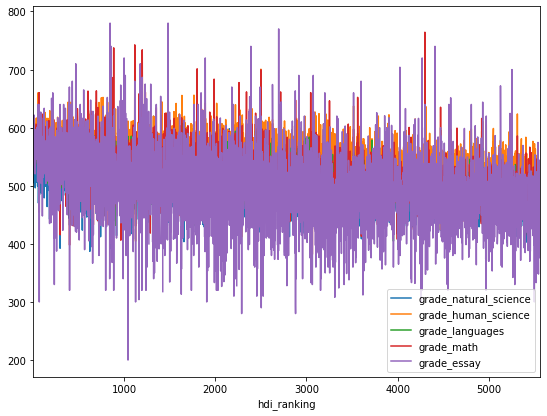

In [9]:
gradeHDIRelation(enem_analysis_df
                     .filter([ 'city_residence'
                              ,'state_residence'
                              ,'grade_natural_science'
                              ,'grade_human_science'
                              ,'grade_languages'
                              ,'grade_math'
                              ,'grade_essay'
                             ])
                     ,cities_analysis_df
                     ,lines=['hdi_ranking']
                    )
a = 1

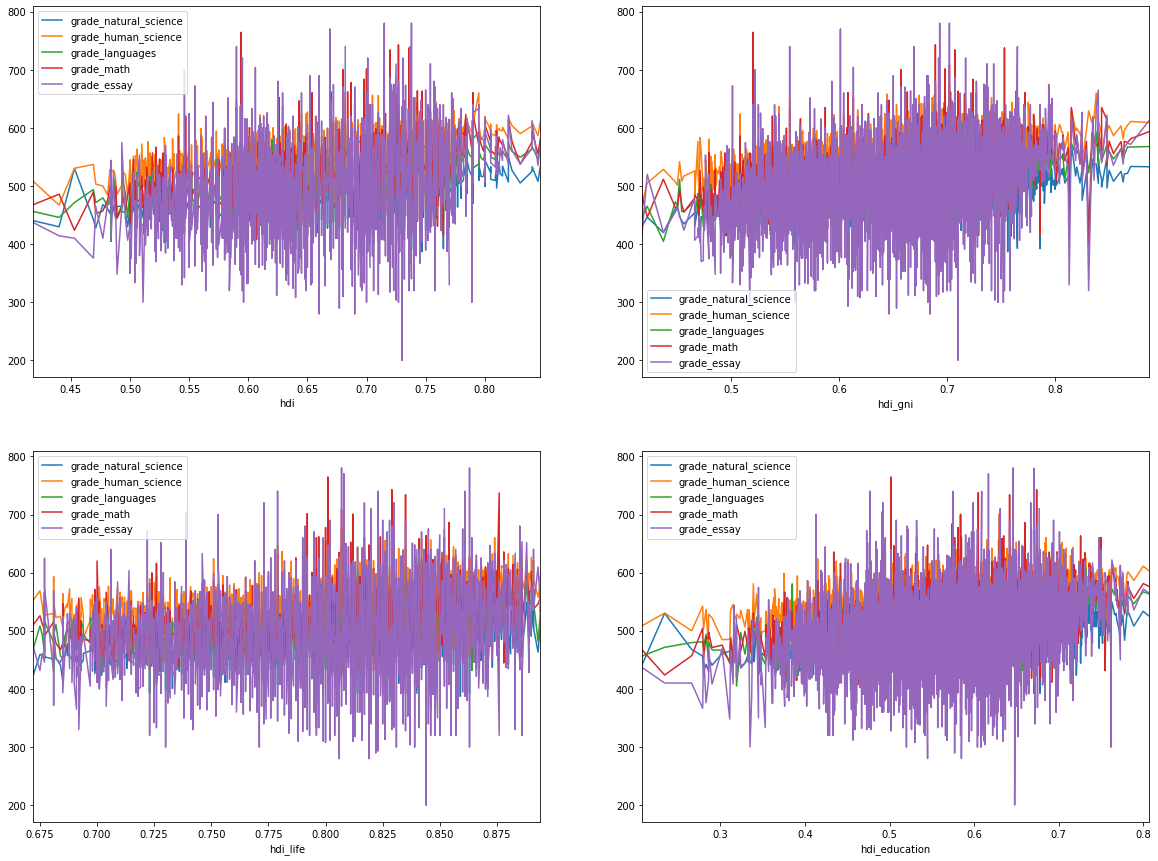

In [10]:
gradeHDIRelation(enem_analysis_df
                     .filter([ 'city_residence'
                              ,'state_residence'
                              ,'grade_natural_science'
                              ,'grade_human_science'
                              ,'grade_languages'
                              ,'grade_math'
                              ,'grade_essay'
                             ])
                     ,cities_analysis_df
                    )
a = 1

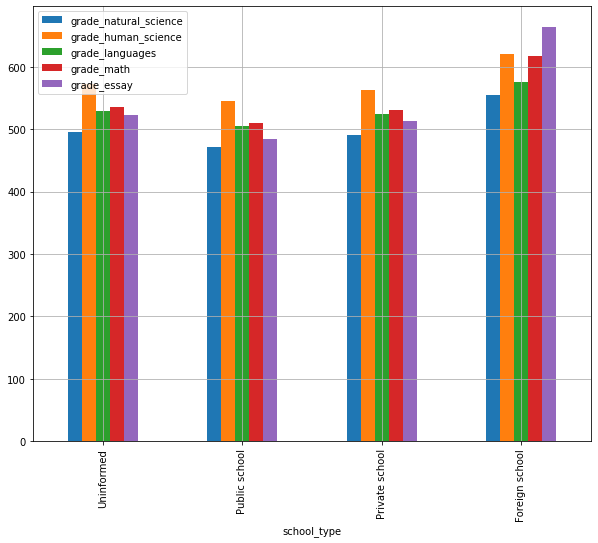

In [11]:
(avg_diff, avg_diff_df) = gradeSchoolRelation(enem_analysis_df
                    .filter([ 'grade_natural_science'
                             ,'grade_human_science'
                             ,'grade_languages'
                             ,'grade_math'
                             ,'grade_essay'
                             ,'school_type'
                             ])
                   )

In [12]:
print_pretty(avg_diff, tabular=True)

content                     grade_natural_science_diff    grade_human_science_diff    grade_languages_diff    grade_math_diff    grade_essay_diff
------------------------  ----------------------------  --------------------------  ----------------------  -----------------  ------------------
avg_diff_private_public                        18.5775                     17.8606                 18.3163            21.7077              29.272
avg_diff_foreign_public                        82.5138                     75.2399                 71.0172           107.597              180.09
avg_diff_foreign_private                       63.9362                     57.3793                 52.701             85.8889             150.817


## 6. Implementation